# QMC integration of non-smooth functions: application to pricing exotic options

**Question 1.** First estimate the value of the integral, as well as the error of the estimation, using a
crude Monte Carlo and a randomized QMC, without the pre-integration trick, i.e., by
generating (Q)MC sample $(x_1, . . . , x_N )$ over the m-dimensional unit cube $[0, 1]^m$. Try increasing values of the sample sizes $N = 2^7, . . . , 2^{13}$ and plot the estimated error versus $N$. Comment on the observed convergence rate.

In [51]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import brentq

np.random.seed(42)

Given quantities and other fixed values used in the project.

In [52]:
# Given values
K = 100.0   # Strike price
S0 = 100.0   # Initial price 
r = 0.1   # Risk-free rate 
sigma = 0.1   # Volatility 
T = 1.0   # Maturity 
m_values = 2 ** np.arange(5,9)   # Numbers of time steps
N_values = 2 ** np.arange(7, 14)   # Sample sizes

# Other fixed quantities
n_shifts = 32 # Number of random shifts for RQMC error estimation

We define the functions which compute discounted payoffs of Asian call options and binary digital Asian options.

In [53]:
def asian_call_payoff(U, K, S0, r, sigma, T, m):
    """
    Computes the discounted payoff of an Asian Call Option.
    Returns an array of discounted payoffs of shape (N,)

    Args:
    U: array of uniform samples of shape (N, m)
    K: strike price
    S0: initial price
    r: risk-free rate
    sigma: volatility
    T: maturity
    m: number of time steps
    """

    dt = T/m   # Size of each time step
    time_grid = np.arange(1, m+1) * dt   # Array [1*dt, ..., m*dt]
    
    # Inverse CDF to get standard normal samples
    xi = st.norm.ppf(U)

    # Array where each of the N rows is a realization of a standard discretized BM
    # Each increment is i.i.d. sqrt(dt) * N(0,1)
    # Each row is the array [W_t1, ..., W_tm] (m elements)
    W = np.cumsum(xi, axis=1) * np.sqrt(dt)
    
    # Array where each of the N rows is values of price S at each time step
    S_path = S0 * np.exp((r - 0.5 * sigma**2) * time_grid + sigma * W)
    
    # Payoff function: (S_avg - K)_+
    # Array of average price of each realization
    S_avg = np.mean(S_path, axis = 1)
    # Array of payoff values
    payoffs = np.maximum(S_avg - K, 0)
    
    # Return array of discounted payoffs
    return np.exp(-r * T) * payoffs

In [54]:
def binary_digital_asian_payoff(U, K, S0, r, sigma, T, m):
    """
    Computes the discounted payoff of a binary digital Asian option.
    Returns an array of discounted payoffs of shape (N,)

    Args:
    U: array of uniform samples of shape (N, m)
    K: strike price
    S0: initial price
    r: risk-free rate
    sigma: volatility
    T: maturity
    m: number of time steps
    """

    dt = T/m   # Size of each time step
    time_grid = np.arange(1, m+1) * dt   # Array [1*dt, ..., m*dt]
    
    # Apply inverse CDF to get standard normal samples
    xi = st.norm.ppf(U)

    # Array where each of the N rows is a realization of a standard discretized BM
    # Each increment is i.i.d. sqrt(dt) * N(0,1)
    # Each row is the array [W_t1, ..., W_tm] (m elements)
    W = np.cumsum(xi, axis=1) * np.sqrt(dt)
    
    # Array where each of the N rows is values of price S at each time step
    S_path = S0 * np.exp((r - 0.5 * sigma**2) * time_grid + sigma * W)
    
    # Payoff function: indicator of {S_avg > K}
    # Array of average price of each realization
    S_avg = np.mean(S_path, axis = 1)
    # Array of payoff values (0 or 1)
    payoffs = (S_avg > K).astype(float)
    
    # Return array of discounted payoffs
    return np.exp(-r * T) * payoffs

Run simulations with different values of N and m (CMC and QMC) and print the results.

(Notation: AC = Asian call option, BDA = binary digital Asian option)

In [55]:
# Repeat simulation for different time step increments
for m in m_values:
    # Lists to store results
    mc_errors_AC = []
    rqmc_errors_AC = []
    mc_means_AC = []
    rqmc_means_AC = []

    mc_errors_BDA = []
    rqmc_errors_BDA = []
    mc_means_BDA = []
    rqmc_means_BDA = []

    # Repeat simulation for different sample sizes
    for N in N_values:

        # Crude Monte Carlo

        # Generate uniform random samples
        U = np.random.rand(N, m)
        
        # Evaluate payoffs
        payoff_values_cmc_AC = asian_call_payoff(U, K, S0, r, sigma, T, m)
        payoff_values_cmc_BDA = binary_digital_asian_payoff(U, K, S0, r, sigma, T, m)
        
        # Compute estimates and errors
        mu_cmc_AC = np.mean(payoff_values_cmc_AC)
        err_cmc_AC = np.std(payoff_values_cmc_AC, ddof = 1) / np.sqrt(N)
        mu_cmc_BDA = np.mean(payoff_values_cmc_BDA)
        err_cmc_BDA = np.std(payoff_values_cmc_BDA, ddof = 1) / np.sqrt(N)
        
        # Add to lists
        mc_means_AC.append(mu_cmc_AC)
        mc_errors_AC.append(err_cmc_AC)
        mc_means_BDA.append(mu_cmc_BDA)
        mc_errors_BDA.append(err_cmc_BDA)


        # Randomized QMC (Sobol)
        # We use Scipy's Sobol generator. 
        # To estimate error, we repeat the simulation 'n_shifts' times with different scrambles.
        
        shift_means_AC = []
        shift_means_BDA = []
        
        for _ in range(n_shifts):
            # Create Sobol sampler
            sampler = st.qmc.Sobol(d=m, scramble=True) 
            # Extracts the next N points from the sequence
            # Gives an array of shape (N, m)
            # N must be power of 2 for Sobol balance properties
            u_rqmc = sampler.random(n=N)
            
            # Evaluate
            payoff_values_qmc_AC = asian_call_payoff(u_rqmc, K, S0, r, sigma, T, m)
            payoff_values_qmc_BDA = asian_call_payoff(u_rqmc, K, S0, r, sigma, T, m)

            shift_means_AC.append(np.mean(payoff_values_qmc_AC))
            shift_means_BDA.append(np.mean(payoff_values_qmc_BDA))

        # RQMC Estimate is the mean of the shifts
        mu_rqmc_AC = np.mean(shift_means_AC)
        mu_rqmc_BDA = np.mean(shift_means_BDA)

        # RQMC Error is the standard deviation of the shift means (approx)
        # We use this as a proxy for the integration error.
        err_rqmc_AC = np.std(shift_means_AC, ddof=1)
        err_rqmc_BDA = np.std(shift_means_BDA, ddof=1)

        rqmc_means_AC.append(mu_rqmc_AC)
        rqmc_errors_AC.append(err_rqmc_AC)
        rqmc_means_BDA.append(mu_rqmc_BDA)
        rqmc_errors_BDA.append(err_rqmc_BDA)

Plots of the estimated errors versus N (using the finest time grid).

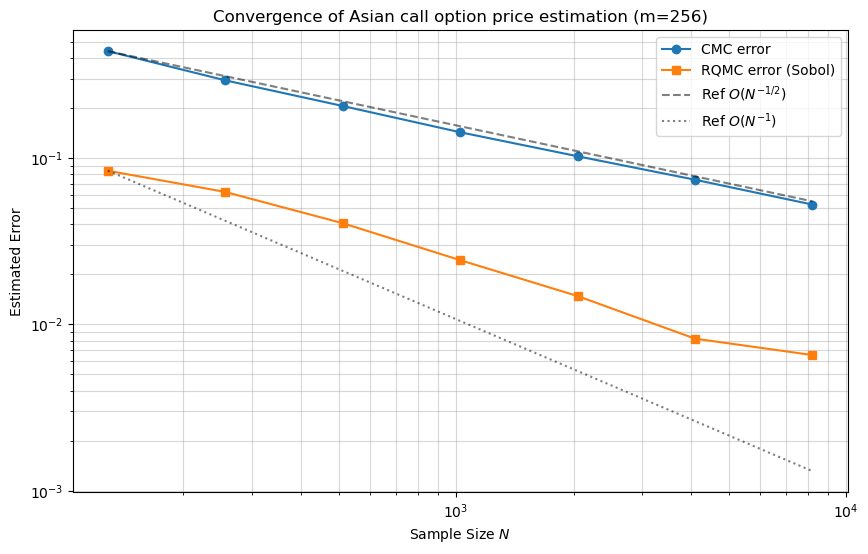

In [56]:
plt.figure(figsize=(10, 6))

# Plot Errors
plt.loglog(N_values, mc_errors_AC, 'o-', label='CMC error')
plt.loglog(N_values, rqmc_errors_AC, 's-', label='RQMC error (Sobol)')


# Reference Lines
ref_x = N_values
ref_mc = 1.0 / np.sqrt(ref_x) * mc_errors_AC[0] * np.sqrt(N_values[0]) # Scale to match start
ref_qmc = 1.0 / ref_x * rqmc_errors_AC[0] * N_values[0] # Scale to match start

plt.loglog(ref_x, ref_mc, 'k--', alpha=0.5, label=r'Ref $O(N^{-1/2})$')
plt.loglog(ref_x, ref_qmc, 'k:', alpha=0.5, label=r'Ref $O(N^{-1})$')

plt.xlabel('Sample Size $N$')
plt.ylabel('Estimated Error')
plt.title(f'Convergence of Asian call option price estimation (m={m})')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()


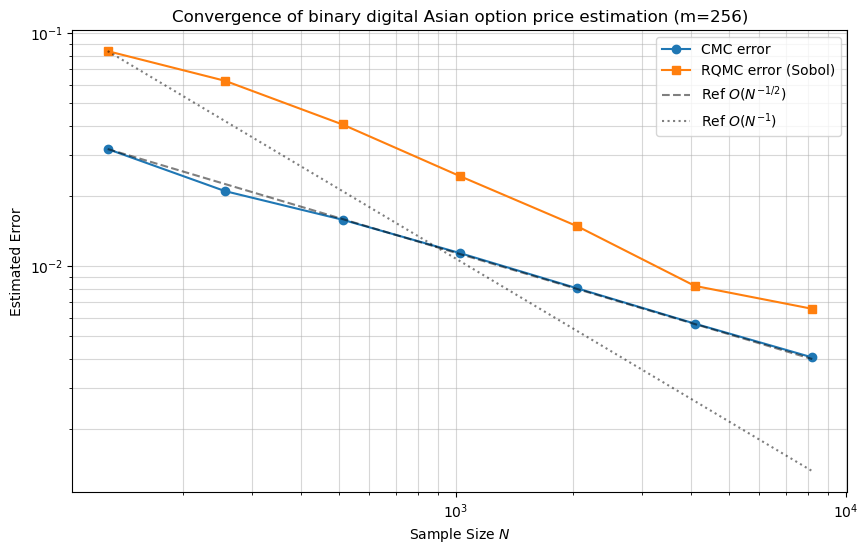

In [57]:
plt.figure(figsize=(10, 6))


# Plot Errors
plt.loglog(N_values, mc_errors_BDA, 'o-', label='CMC error')
plt.loglog(N_values, rqmc_errors_BDA, 's-', label='RQMC error (Sobol)')

# Reference Lines
ref_x = N_values
ref_mc = 1.0 / np.sqrt(ref_x) * mc_errors_BDA[0] * np.sqrt(N_values[0]) # Scale to match start
ref_qmc = 1.0 / ref_x * rqmc_errors_BDA[0] * N_values[0] # Scale to match start

plt.loglog(ref_x, ref_mc, 'k--', alpha=0.5, label=r'Ref $O(N^{-1/2})$')
plt.loglog(ref_x, ref_qmc, 'k:', alpha=0.5, label=r'Ref $O(N^{-1})$')

plt.xlabel('Sample Size $N$')
plt.ylabel('Estimated Error')
plt.title(f'Convergence of binary digital Asian option price estimation (m={m})')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

**Question 2.** Implement now the pre-integration trick. First, generate randomized (Q)MC points
over $[0,1]^{m−1}$, and decide on which direction $x_j$ to perform the integration. Discuss
your choice (or, alternatively, compare numerically different choices) depending also on
the adopted re-parametrization of the Brownian path. Use the pre-integration approach
to estimate $V_i$ using both QMC and MC. Estimate your (Q)Monte Carlo error using
sample sizes $N = 2^7,...,2^{13}$. Plot the estimated error versus $N$. Compare your results
to those obtained in point 1 in terms of error and computational cost.

Helper functions to implement the pre-integration trick.

In [ ]:

def get_gradient(f, z):
    """
    Computes numerical gradient of function f at point z.
    Returns the gradient.

    Args:
    f: function
    z: point where to evaluate
    """
    epsilon = 1e-5
    d = len(z)   # dimension of the array

    # Initialize gradient as an array of zeros
    grad = np.zeros(d)
    base_val = f(z)

    # Compute the gradient numerically
    for i in range(d):
        z_perturbed = z.copy()
        z_perturbed[i] += epsilon
        grad[i] = (f(z_perturbed) - base_val) / epsilon

    return grad


def compute_active_subspace(payoff_function, d):
    """
    Finds the dominant direction 'u' (eigenvector of C matrix).
    Returns the array u.

    Args:
    payoff_function:
    d: dimension (will be various values of m)
    """
    n_pilot = 256   # Number of draws for pilot run

    # Generate pilot samples
    sampler = st.qmc.Sobol(d=d, scramble=True)
    z_pilot = st.norm.ppf(sampler.random(n_pilot))
    
    # Compute gradients at each point
    grads = []   # Empty list to store gradients
    for i in range(n_pilot): 
        g = get_gradient(payoff_function, z_pilot[i])
        grads.append(g)
    grads = np.array(grads)   # Turn the list into a numpy array
    
    # C = E[grad(psi) * grad(psi)^T]
    C = (grads.T @ grads) / n_pilot

    # Eigendecomposition of the outer product matrix
    eigvals, eigvecs = np.linalg.eigh(C)
    
    # The dominant direction is the eigenvector with largest eigenvalue
    # Will be the last column of the eigvecs array
    u = eigvecs[:, -1]
    
    # Ensure consistent sign
    if np.sum(u) < 0: u = -u

    return u


def householder_matrix(u):
    """
    Creates an orthogonal matrix Q such that Q @ e1 is parallel to u.
    This rotates the first axis to align with direction u.
    """
    d = len(u)
    # Target direction: e1 = [1, 0, ..., 0]
    e1 = np.zeros(d)
    e1[0] = 1.0
    
    # Standard Householder construction
    sign = np.sign(u[0]) if u[0] != 0 else 1
    v = u + sign * np.linalg.norm(u) * e1
    v = v / np.linalg.norm(v)
    H = np.eye(d) - 2 * np.outer(v, v)
    
    # H reflects e1 to -sign*u. We adjust sign to get +u
    return H * (-sign)

Implementation of the pre-integration.

In [59]:
def asian_call_pre_integration(z_perp, u, Q, K, S0, r, sigma, T, m):
    """
    Estimates Asian Call Price by integrating one variable analytically
    along the direction 'u' (defined by rotation Q).
    
    Args:
    z_perp: (N, m-1) Standard Normal samples
    u: (m,) The direction vector
    Q: (m, m) The rotation matrix
    """
    N = z_perp.shape[0]
    dt = T / m
    time_grid = np.arange(1, m + 1) * dt
    
    # We are simulating W = Q @ [v, z_perp] (scaled by sqrt(dt))
    # But we work directly with the linear combination in the exponent.
    
    # The drift and volatility terms for the asset price S_t
    drift_vec = (r - 0.5 * sigma**2) * time_grid
    
    # Brownian transformation matrix A (Lower triangular of C)
    times = np.linspace(dt, T, m)
    Cov = np.minimum(times[:, None], times[None, :])
    A = np.linalg.cholesky(Cov) # shape (m, m)
    
    # Projection of our rotated basis onto the Brownian path space
    # The first column of Q corresponds to v (the integration var)
    # The rest correspond to z_perp (the sampled vars)
    AU_v = A @ Q[:, 0]      # shape (m,) -> Influence of v on path
    AU_perp = A @ Q[:, 1:]  # shape (m, m-1) -> Influence of z_perp on path
    
    # Initialize array of estimates
    estimates = np.zeros(N)
    
    # Pre-compute the 'random' part of the path coming from z_perp
    # shape (N, m)
    path_random_part = z_perp @ AU_perp.T 
    
    for i in range(N):
        # For this specific sample, the path is:
        # ln(S_t/S0) = drift + sigma * (path_random_part[i] + v * AU_v)
        
        # We define a function g(v) = Mean(S(v)) - K
        # We need to find v such that g(v) = 0
        
        # Extract constants for this i to speed up the solver
        # Alpha[t] = S0 * exp(drift_t + sigma * random_part_t)
        # Beta[t]  = sigma * AU_v_t
        alpha = S0 * np.exp(drift_vec + sigma * path_random_part[i])
        beta  = sigma * AU_v
        
        # The equation: mean( alpha * exp(beta * v) ) - K = 0
        def g(v):
            return np.mean(alpha * np.exp(beta * v)) - K
        
        # Root finding (Find the boundary v_star)
        try:
            # We look for root in [-10, 10] (roughly +/- 10 std devs)
            v_star = brentq(g, -10, 10)
            
            # If we found a root, compute the integral
            # Integral = Discount * E[ (Mean(S) - K) * Ind(v > v_star) ]
            # This splits into two terms (Black-Scholes style)
            
            # Term 1: E[ Mean(S) * Ind(v > v_star) ]
            # = (1/m) * Sum( E[ S_t * Ind(v > v_star) ] )
            # E[S_t * Ind] = alpha_t * exp(beta_t^2 / 2) * Phi( beta_t - v_star )
            term1_vals = alpha * np.exp(0.5 * beta**2) * st.norm.cdf(beta - v_star)
            term1 = np.mean(term1_vals)
            
            # Term 2: - K * P(v > v_star)
            term2 = K * st.norm.cdf(-v_star)
            
            estimates[i] = np.exp(-r*T) * (term1 - term2)
            
        except ValueError:
            # Root not found in range. 
            # Check if we are always ITM (g(-10) > 0) or always OTM (g(10) < 0)
            if g(0) > 0: 
                # Always In-The-Money (Payoff is roughly Forward - K)
                # Using v_star = -infinity
                term1_vals = alpha * np.exp(0.5 * beta**2)
                estimates[i] = np.exp(-r*T) * (np.mean(term1_vals) - K)
            else:
                # Always Out-The-Money
                estimates[i] = 0.0

    return estimates

In [60]:
#TODO: function for binary digitial pre int

Run the simulations.

In [ ]:

# Lists to store results (will be overwritten for each m, keeping only the last)
mc_errors_AC = []
rqmc_errors_AC = []


for m in m_values:
    print(f"\nProcessing m = {m}...")
    
    # Determine optimal direction for this m
    # Define a local wrapper for the raw payoff to find gradients
    def raw_payoff_wrapper(z):
        # Local Cholesky for the pilot run (size m)
        times = np.linspace(T/m, T, m)
        Cov = np.minimum(times[:,None], times[None,:])
        A = np.linalg.cholesky(Cov)
        path = S0 * np.exp((r - 0.5*sigma**2)*times + sigma*(A@z))
        return np.maximum(np.mean(path) - K, 0)

    # Compute u and Q
    u_opt = compute_active_subspace(raw_payoff_wrapper, d=m)
    Q_opt = householder_matrix(u_opt)
    
    # Run Simulation for this m
    # Reset lists for the current m
    mc_errors_AC = []
    rqmc_errors_AC = []
    
    for N in N_values:
        # 1. Crude MC + Smoothing
        z_perp = np.random.normal(size=(N, m-1))
        y_mc = asian_call_pre_integration(z_perp, u_opt, Q_opt, K, S0, r, sigma, T, m)
        
        err_mc = np.std(y_mc, ddof=1) / np.sqrt(N)
        mc_errors_AC.append(err_mc)
        
        # 2. RQMC + Smoothing
        sampler = st.qmc.Sobol(d=m-1, scramble=True)
        shift_means = []
        
        for _ in range(n_shifts):
            u_pts = sampler.random(n=N)
            z_pts = st.norm.ppf(u_pts)
            y_rqmc = asian_call_pre_integration(z_pts, u_opt, Q_opt, K, S0, r, sigma, T, m)
            shift_means.append(np.mean(y_rqmc))
            
        err_rqmc = np.std(shift_means, ddof=1)
        rqmc_errors_AC.append(err_rqmc)
        
    print(f"  -> Done. Last RQMC Error: {rqmc_errors_AC[-1]:.2e}")





Processing m = 32...
  -> Done. Last RQMC Error: 2.12e-05

Processing m = 64...
  -> Done. Last RQMC Error: 2.61e-05

Processing m = 128...
  -> Done. Last RQMC Error: 5.16e-05

Processing m = 256...


c:\Users\Matteo\anaconda3\envs\StochasticSimulation\Lib\site-packages\numpy\_core\_methods.py:190: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


  -> Done. Last RQMC Error: 9.40e-05


Plots

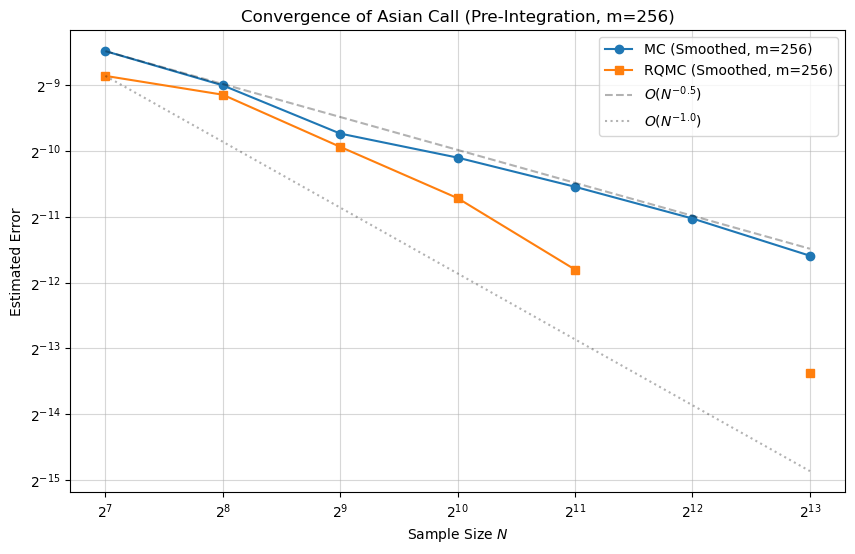

In [62]:
plt.figure(figsize=(10, 6))

# Plot the data currently stored in the lists (which is from the last m)
plt.loglog(N_values, mc_errors_AC, 'o-', label=f'MC (Smoothed, m={m})', base=2)
plt.loglog(N_values, rqmc_errors_AC, 's-', label=f'RQMC (Smoothed, m={m})', base=2)

# Reference Lines
ref_mc = [mc_errors_AC[0] * (N_values[0]/n)**0.5 for n in N_values]
plt.loglog(N_values, ref_mc, 'k--', alpha=0.3, label='$O(N^{-0.5})$', base=2)

ref_rqmc = [rqmc_errors_AC[0] * (N_values[0]/n)**1.0 for n in N_values]
plt.loglog(N_values, ref_rqmc, 'k:', alpha=0.3, label='$O(N^{-1.0})$', base=2)

plt.xlabel('Sample Size $N$')
plt.ylabel('Estimated Error')
plt.title(f'Convergence of Asian Call (Pre-Integration, m={m})')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()